## Procesamiento de Lenguaje Natural (Correos Soporte OVT)

### Prepocesamiento de datos

Como primera tecnica de preprocesamiento separaremos lo correos entrantes de los correos salientes

In [21]:
import os
from email import policy
from email.parser import BytesParser
import shutil

directorio_correos = 'C:/Users/TOSHIBA/Desktop/IA MINISTERIO/correos'
directorio_entrante = 'C:/Users/TOSHIBA/Desktop/IA MINISTERIO/entrantes'
directorio_saliente = 'C:/Users/TOSHIBA/Desktop/IA MINISTERIO/salientes'

os.makedirs(directorio_entrante, exist_ok=True)
os.makedirs(directorio_saliente, exist_ok=True)


In [14]:
def parse_email(path):
    with open(path, 'rb') as f:
        correo = BytesParser(policy=policy.default).parse(f)
    return correo

In [22]:
def correo_entrante(correo, dominio):
    from_address = correo['From']
    if from_address and dominio not in from_address:
        return True
    return False


In [19]:
def separar_correos(directorio_correos, dominio, entrantes, salientes):
    for mes in ["enero", "febrero", "marzo", "abril", "mayo", "junio"]:
        directorio_meses = os.path.join(directorio_correos, mes)
        for raiz, _, archivos in os.walk(directorio_meses):
            for archivo in archivos:
                if archivo.endswith('.eml'):
                    ruta_archivo = os.path.join(raiz, archivo)
                    mensaje_correo = parse_email(ruta_archivo)
                    if correo_entrante(mensaje_correo, dominio):
                        dest_dir = os.path.join(entrantes, mes)
                    else:
                        dest_dir = os.path.join(salientes, mes)
                    os.makedirs(dest_dir, exist_ok=True)
                    shutil.copy(ruta_archivo, os.path.join(dest_dir, archivo))

In [ ]:
dominio = '@mintrabajo.gob.bo' 
separar_correos(directorio_correos, dominio, directorio_entrante, directorio_saliente)

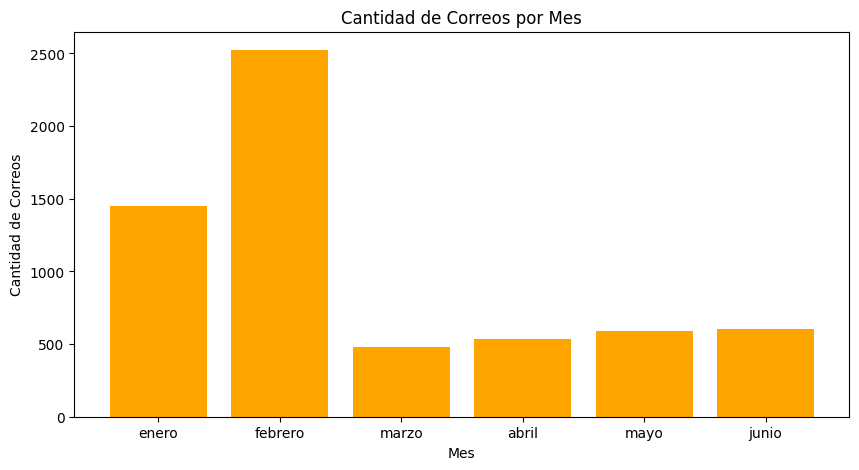

In [27]:
import os
import matplotlib.pyplot as plt
def cotar_correos_mes(directorio):
    contador = {}
    for mes in ["enero", "febrero", "marzo", "abril", "mayo", "junio"]:
        directorio_mes = os.path.join(directorio, mes)
        if os.path.exists(directorio_mes):
            contador[mes] = len([name for name in os.listdir(directorio_mes) if name.endswith('.eml')])
        else:
            contador[mes] = 0
    return contador

contador = cotar_correos_mes(directorio_entrante)

meses = list(contador.keys())
conteo = list(contador.values())

plt.figure(figsize=(10, 5))
plt.bar(meses, conteo, color='orange')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Correos')
plt.title('Cantidad de Correos por Mes')
plt.show()

In [28]:
print(meses, conteo)

['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio'] [1448, 2523, 477, 537, 592, 605]


Continuaremos con las tecnicas de preprocesamiento de datos, aplicaremos la conversión de los caracteres aminusculas, se eiliminaran las URL's adjuntas, se eliminaran las etiquetas HTML, se eliminaran los caracteres especiales y de puntuación ademas se realizara la tokenización respecto a palabras vacias y la lematización

In [1]:
import os
from email import policy
from email.parser import BytesParser
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import nltk

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load('es_core_news_sm')
stop_words = set(stopwords.words('spanish'))

def parse_email(ruta):
    with open(ruta, 'rb') as f:
        correo = BytesParser(policy=policy.default).parse(f)
    return correo

def get_text_from_email(email):
    if email.is_multipart():
        for part in email.walk():
            content_type = part.get_content_type()
            content_disposition = str(part.get("Content-Disposition"))
            if content_type == "text/plain" and "attachment" not in content_disposition:
                charset = part.get_content_charset()
                return part.get_payload(decode=True).decode(charset, errors="ignore")
    else:
        charset = email.get_content_charset()
        return email.get_payload(decode=True).decode(charset, errors="ignore")
    return None

def preprocesar_texto(texto):
    soup = BeautifulSoup(texto, 'html.parser')
    texto = soup.get_text()

    texto = texto.lower()
    texto = re.sub(r'http\S+|www.\S+', '', texto)
    texto = re.sub(r'\S+@\S+', '', texto)
    texto = re.sub(r'[^a-zA-Z0-9\s]', '', texto)

    tokens = word_tokenize(texto)
    tokens = [palabra for palabra in tokens if palabra not in stop_words]
    tokens = [nlp(palabra)[0].lemma_ for palabra in tokens]

    return ' '.join(tokens)

def preprocesar_correos(ruta, ruta_salida):
    os.makedirs(ruta_salida, exist_ok=True)
    for mes in ["enero", "febrero", "marzo", "abril", "mayo", "junio"]:
        directorio_meses = os.path.join(ruta, mes)
        directorio_salida_mes = os.path.join(ruta_salida, mes)
        os.makedirs(directorio_salida_mes, exist_ok=True)
        if not os.path.exists(directorio_meses):
            print(f"Directorio {directorio_meses} no existe.")
            continue
        for raiz, _, archivos in os.walk(directorio_meses):
            for archivo in archivos:
                if archivo.endswith('.eml'):
                    ruta_archivo = os.path.join(raiz, archivo)
                    correo = parse_email(ruta_archivo)
                    cuerpo = get_text_from_email(correo)
                    if cuerpo:
                        cuerpo_preprocesado = preprocesar_texto(cuerpo)
                        nombre_archivo_salida = os.path.join(directorio_salida_mes, archivo.replace('.eml', '.txt'))
                        with open(nombre_archivo_salida, 'w', encoding='utf-8') as f:
                            f.write(cuerpo_preprocesado)
                        print(f"Correo procesado y guardado: {nombre_archivo_salida}")
                    else:
                        print(f"No se encontró cuerpo de texto en: {ruta_archivo}")

directorio_entrante = "C:/Users/Rick/Desktop/OVT/entrantes"
directorio_salida = "C:/Users/Rick/Desktop/OVT/entrantes_procesados"
preprocesar_correos(directorio_entrante, directorio_salida)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000047637-Error en la pagina de la OVT 15 de octubre.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000079406-RECLAMO POR COMUNICADO DE INCUMPLIMIENTO DE PRESENTACION DE PLANILLAS.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000085895-Consulta-Cambio de Contraseña Min. Trabajo.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000085896-CONSULTA CAMBIO DE CONTRASEÑA MINISTERIO DE TRABAJO-EMPRESA VMELITE BOLIVIA S.R.L.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000085935-RE_ CONSULTA CAMBIO DE CONTRASEÑA MINISTERIO DE TRABAJO-EMPRESA VMELITE BOLIVIA S.R.L.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000085937-RE_ CONSULTA CAMBIO DE CONTRASEÑA MINISTERIO DE TRABAJO-EMPRESA VMELITE BOLIVIA S.R.L.txt
Correo p

C:\Users\Rick\AppData\Local\Temp\ipykernel_2492\1943780694.py:36: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(texto, 'html.parser')


Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000110587-RE_ INCUMPLIMIENTO CON LA PRESENTACIÓN DE PLANILLAS- DESCARGO CONCUADRA SRL.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000110590-PRESENTACIÓN DE PLANILLAS GRUPO GEO SRL G-2023.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000110593-RE_ INCUMPLIMIENTO CON LA PRESENTACIÓN DE PLANILLAS.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000110594-RE_ INCUMPLIMIENTO CON LA PRESENTACIÓN DE PLANILLAS.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000110608-RESPUESTA A INCUMPLIMIENTO CON LA PRESENTACIÓN DE PLANILLAS.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\enero\0000110609-Re_ INCUMPLIMIENTO CON LA PRESENTACIÓN DE PLANILLAS.txt
Correo procesado y guardado: C:/Users/Rick/Desktop/OVT/entrantes_procesados\ene

TypeError: decode() argument 'encoding' must be str, not None